In [1]:
#!L
import torch
print (torch.cuda.device_count())
print (torch.__version__)

1
1.11.0+cu113


In [2]:
%pip install scikit-image scikit-learn

### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet - one of the most popular classification datasets.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [3]:
import requests
import os

# class labels
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
labels = {int(key):value[1] for (key, value) in requests.get(LABELS_URL).json().items()}

In [4]:
print(list(labels.items())[:5])

[(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


In [5]:
print(list(filter(lambda x: 'banana' in x[1], labels.items())))

[(954, 'banana')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use resnet-50 network.

![img](https://miro.medium.com/max/1000/1*YQgpwj-Wde7r8bFqXy2ruw.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [6]:
#!L
from torchvision.models.resnet import resnet50

model = resnet50(pretrained=True,      # load existing weights
                    )

model.train(False)
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
#!L
import torch

dummy_x = torch.randn(5, 3, 224, 224).cuda()
model(dummy_x).cpu()

tensor([[-9.0780e-01,  2.2065e-01, -3.6161e-02,  ..., -2.3441e+00,
         -9.7691e-01,  1.4565e+00],
        [-2.1225e-01, -2.7633e-02, -1.4473e-01,  ..., -2.2168e+00,
         -9.9658e-01,  1.1850e+00],
        [-7.9305e-01, -6.7080e-02, -2.5978e-01,  ..., -2.6614e+00,
         -9.1917e-01,  1.5854e+00],
        [-6.3883e-01,  1.4637e-02, -1.0225e-01,  ..., -2.5876e+00,
         -6.9601e-01,  1.3575e+00],
        [-4.6355e-01,  1.8897e-03,  4.5579e-03,  ..., -2.7640e+00,
         -8.9603e-01,  1.1632e+00]], grad_fn=<ToCopyBackward0>)

### Predict class probabilities

In [8]:
# If using Colab
os.system('mkdir -p sample_images')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg')

0

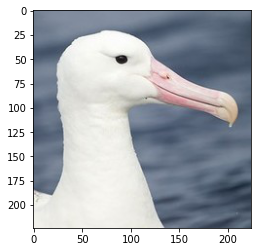

top-10 classes are: 
 [prob : class label]
0.9938 :	albatross
0.0023 :	spoonbill
0.0011 :	hammerhead
0.0006 :	American_egret
0.0005 :	goose
0.0003 :	pelican
0.0003 :	oystercatcher
0.0002 :	ptarmigan
0.0001 :	crane


In [9]:
#!L
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (224, 224))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 224, 224, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img).cuda()
    
    probs = torch.nn.functional.softmax(model(img), dim=-1).cpu()
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [10]:
os.system("wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg")

0

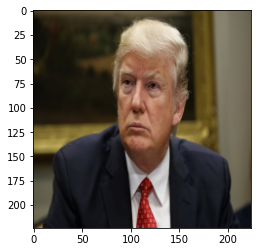

top-10 classes are: 
 [prob : class label]
0.4820 :	suit
0.4616 :	Windsor_tie
0.0227 :	bolo_tie
0.0054 :	lab_coat
0.0054 :	groom
0.0031 :	bow_tie
0.0017 :	hourglass
0.0016 :	trench_coat
0.0009 :	stethoscope


In [11]:
#!L
img = resize(plt.imread('img.jpg'), (224, 224))
plt.imshow(img)
plt.show()

predict(img)

Let's introduce a bit of our brand-new reality into the seminar!

In [12]:
os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/seminar04-finetuning/sample_images/plague-doctor-mask.jpg -O sample_images/mask.jpg")

0

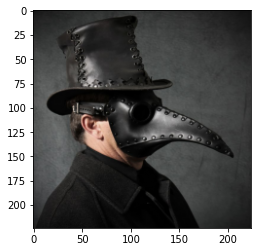

top-10 classes are: 
 [prob : class label]
0.0962 :	sunglass
0.0960 :	cowboy_hat
0.0957 :	revolver
0.0640 :	sunglasses
0.0570 :	trench_coat
0.0526 :	cornet
0.0482 :	gasmask
0.0232 :	hoopskirt
0.0229 :	mask


In [13]:
#!L
img = resize(plt.imread('sample_images/mask.jpg'), (224, 224))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [14]:
os.system("wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip")
os.system("unzip -n data.zip")

0

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [15]:
#!L
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity().cuda()

assert embedding(transform_input(img).cuda()).cpu().data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [16]:
#!L

#extract features from images
from tqdm import tqdm
from skimage.io import imread
import skimage
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 32
imgs = np.zeros([batch_size, 224, 224, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = skimage.img_as_ubyte(imread(os.path.join("train", fname)))
    
    img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor.cuda()).cpu().data.numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 25000/25000 [06:12<00:00, 67.11it/s]


In [17]:
#!L
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24992, 2048) (24992,)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [19]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [20]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)

DecisionTreeClassifier()

In [21]:
print(np.mean(np.argmax(cl.predict_proba(X_val), axis=-1) == y_val))

0.9436619718309859


In [22]:
cl = LogisticRegression()
cl.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [23]:
print(np.mean(np.argmax(cl.predict_proba(X_val), axis=-1) == y_val))

0.9806338028169014


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [24]:
#!L
import torch.nn as nn

from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

embedding.fc = nn.Linear(2048, 2).cuda()

assert embedding(transform_input(img).cuda()).cpu().data.numpy().shape == (1, 2), "your output for single image should have shape (1, 2048)"

In [25]:
import random
names = os.listdir("train")

random.shuffle(names)
train_names = names[2000:]
val_names = names[:2000]

In [27]:
#!L

#extract features from images
from tqdm import tqdm
from skimage.io import imread
import skimage
import PIL.Image as Image
import os
import numpy as np


def validate(model, names):
    imgs = np.zeros([batch_size, 224, 224, 3])
    batch_index = 0
    n_correct = 0.0

    for fname in tqdm(names):
        y = fname.startswith("cat")
        
        img = skimage.img_as_ubyte(imread(os.path.join("train", fname)))
        
        img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
        imgs[batch_index] = img
        
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
        
        # use your embedding model to produce feature vector
        features = model(input_tensor.cuda()).cpu().data.numpy()

        if features.ravel().argmax() == int(y):
            n_correct += 1
    return n_correct / len(names)

In [28]:
print(validate(model, val_names))

100%|██████████| 2000/2000 [09:21<00:00,  3.56it/s]

0.0


In [37]:
#!L

#extract features from images
from tqdm import tqdm
from skimage.io import imread
import skimage
import PIL.Image as Image
import os
import numpy as np
from torch.optim import Adam

Y = []

batch_size = 32
imgs = np.zeros([batch_size, 224, 224, 3])
batch_index = 0

opt = Adam(embedding.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

for fname in tqdm(train_names):
    y = fname.startswith("cat")
    Y.append(int(y))

    img = skimage.img_as_ubyte(imread(os.path.join("train", fname)))
    
    img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
        
        # use your embedding model to produce feature vector

        embedding.zero_grad()

        preds = embedding(input_tensor.cuda())
        loss = criterion(preds, torch.tensor(Y, device="cuda"))
        loss.backward()
        opt.step()

        batch_index = 0
        Y = []
        continue

    batch_index += 1

100%|██████████| 23000/23000 [14:41<00:00, 26.09it/s]


In [39]:
res = validate(embedding, val_names)

100%|██████████| 2000/2000 [09:21<00:00,  3.56it/s]


In [40]:
print(res)

0.979


# Bonus: #deepdream

Probably it's better to use inception-v3 network here

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [12]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [13]:
modulelist = list(model.children())
print(len(modulelist))

10


In [35]:
#!L
preprocess = transforms.Compose([
#    transforms.Resize((224, 224)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True, device='cuda:0', 
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [36]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

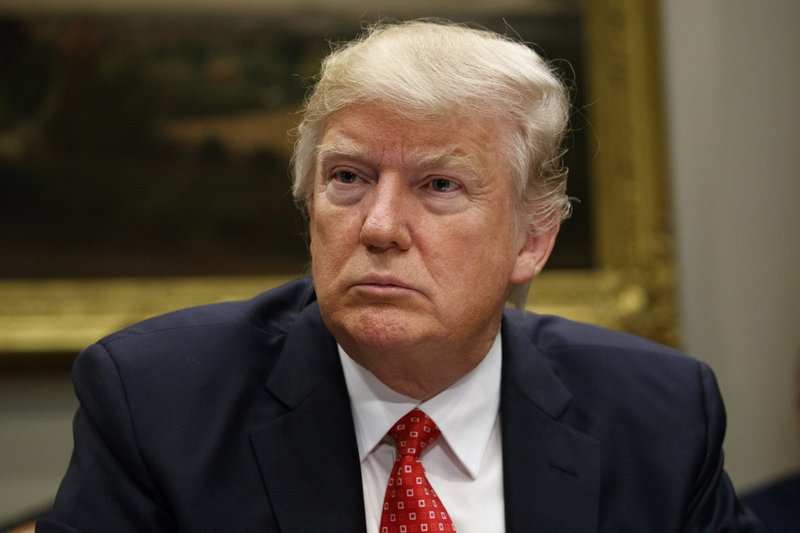

In [37]:
img = Image.fromarray(plt.imread('img.jpg'))
img

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


-------------- Recursive level:  6 --------------
-------------- Recursive level:  7 --------------
-------------- Recursive level:  8 --------------
-------------- Recursive level:  9 --------------
-------------- Recursive level:  10 --------------
-------------- Recursive level:  11 --------------
-------------- Recursive level:  12 --------------
-------------- Recursive level:  13 --------------
-------------- Recursive level:  14 --------------
-------------- Recursive level:  15 --------------
-------------- Recursive level:  16 --------------
-------------- Recursive level:  17 --------------
-------------- Recursive level:  18 --------------
-------------- Recursive level:  19 --------------
-------------- Recursive level:  20 --------------


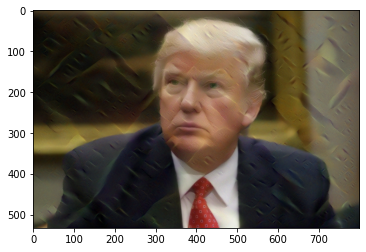

In [38]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

-------------- Recursive level:  0 --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------
-------------- Recursive level:  6 --------------
-------------- Recursive level:  7 --------------
-------------- Recursive level:  8 --------------
-------------- Recursive level:  9 --------------
-------------- Recursive level:  10 --------------
-------------- Recursive level:  11 --------------
-------------- Recursive level:  12 --------------
-------------- Recursive level:  13 --------------
-------------- Recursive level:  14 --------------
-------------- Recursive level:  15 --------------
-------------- Recursive level:  16 --------------
-------------- Recursive level:  17 --------------
-------------- Recursive level:  18 --------------
-------------- Recursive level:  19 --------------
-------------- Recursive level:  20 ----

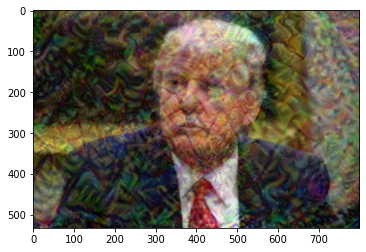

In [40]:
output = deep_dream(img, 9, 5, 0.2, 2, 20)

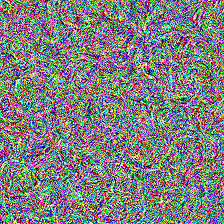

In [111]:
import torch.nn as nn

def make_dream(model, label, num_iterations, lr, lamb):
    noise = torch.rand(1, 3, 224, 224).cuda()
    noise.requires_grad = True

    for i in range(num_iterations):
        model.zero_grad()

        out = model(noise)
        loss = out[0, label] - lamb * (noise.norm() ** 2)

        loss.backward()
    
        noise.data = noise.data + lr * noise.grad.data

    im = noise.data.squeeze(0).cpu()
    im.transpose_(0, 1)
    im.transpose_(1, 2)
    im = np.clip(im, 0, 1)
    im = Image.fromarray(np.uint8(im * 255))
    return im

BANANA_LABEL = 954
make_dream(model, BANANA_LABEL, 200, 1, 1)

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True, device='cuda:0',
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data - lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [117]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, 10, 5, 0.2)   # YOUR CODE
img_adv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


RuntimeError: ignored

In [ ]:
predict(resize(np.asarray(img_adv), (224, 224)))